# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

# Часть 1. SVM, LR и калибровка вероятностей

In [13]:
!pip install --upgrade scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание. Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [5]:
average_precision_score(y_test,y_random)

0.5076535567202073

AUC-PR: 0.63340
AUC-ROC: 0.50394


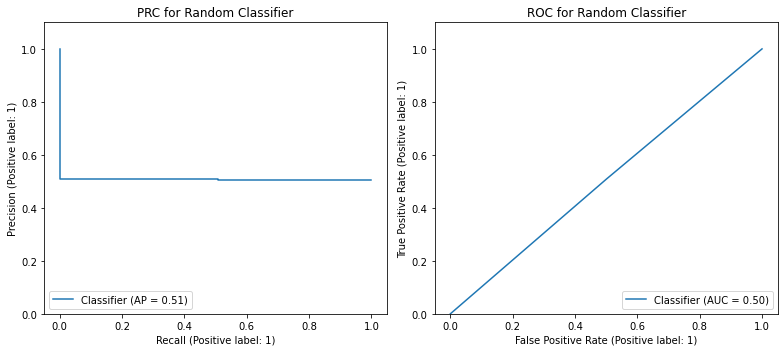

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, t = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

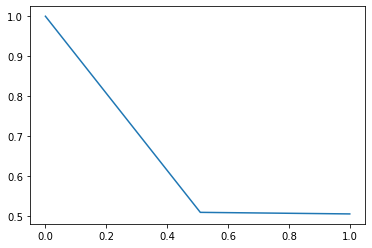

In [38]:
plt.plot(recall,precision)

In [35]:
precision[::-1]

array([1.        , 0.50957096, 0.50566667])

In [36]:
recall[::-1]

array([0.        , 0.50889914, 1.        ])

In [22]:
t

array([0, 1])

In [20]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

def metric(y,y_pred):
    precision, recall, _ = precision_recall_curve(y, y_pred)
    return auc(recall, precision)

model = SVC()
c = [0.001, 0.01, 0.1, 1, 10]
sc = []

for i in c:
    model = SVC(kernel = 'linear', C = i)
    sc.append(np.mean(cross_val_score(model, X_train, y_train, cv=3,scoring = make_scorer(metric))))

In [42]:
sc

[0.8356009725357657,
 0.8355613744064696,
 0.8355730587938041,
 0.835460919529644,
 0.8355728620484623]

Best C = 0.1

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.83392
AUC-ROC: 0.77547


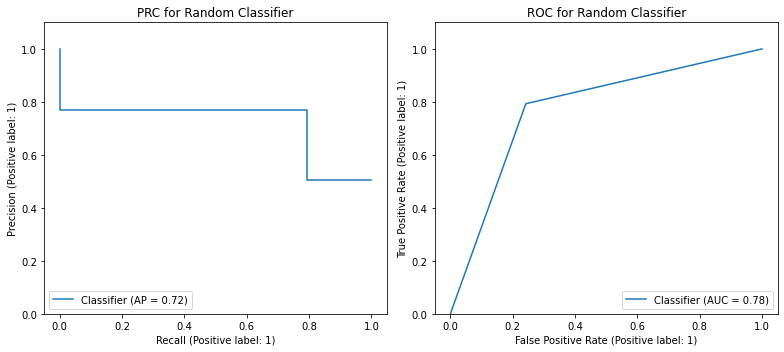

In [43]:
model = SVC(kernel = 'linear', C = 0.1)
model.fit(X_train, y_train)
r = model.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, r, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, r)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, r, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, r))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Обученная модель показало значительно лучшее качество, по сравнению с случайным классификатором

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [46]:
from sklearn.linear_model import LogisticRegression

In [24]:
from sklearn.linear_model import LogisticRegression

def metric(x,y):
    precision, recall, _ = precision_recall_curve(x, y)
    return auc(recall, precision)

c = [1000, 100, 10, 1, 0.1]
sc = []

for i in c:
    model = LogisticRegression(penalty='l2', C = i)
    sc.append(np.mean(cross_val_score(model, X_train, y_train, cv=7,scoring = make_scorer(metric))))

In [25]:
sc

[0.8358104098896485,
 0.8358104098896485,
 0.8358104098896485,
 0.8358104098896485,
 0.8352894617843108]

AUC-PR: 0.83116
AUC-ROC: 0.77134


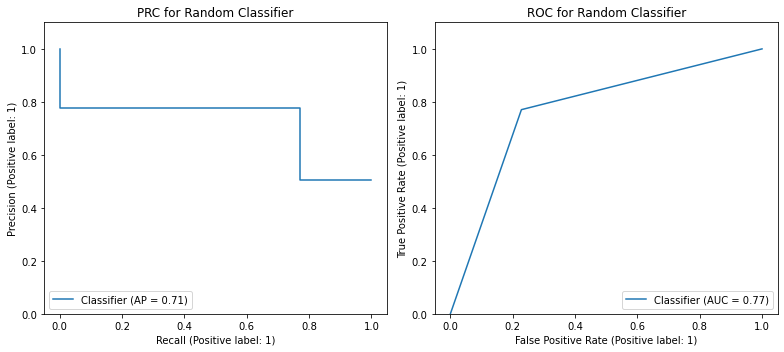

In [26]:
model = LogisticRegression(penalty='l2', C = 10)
model.fit(X_train, y_train)
r = model.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, r, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, r)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, r, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, r))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: Логистическая регрессия и SVM (с линейным ядром) с точки зрения Auc-Roc'а' и PR-curve показали очень близки результаты обеих метрик

#### __Задание. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [27]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative = 2, n_redundant = 0,random_state=42)

model = SVC(kernel = 'linear', C = 0.1)
clf = model.fit(X,y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


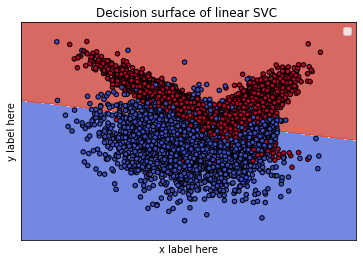

In [28]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


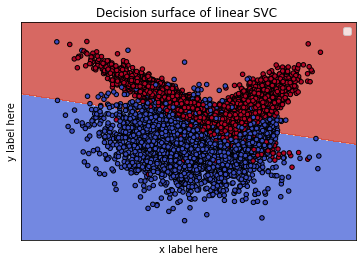

In [29]:
model = LogisticRegression(penalty='l2', C = 10)
clf = model.fit(X, y)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

#### __Задание. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [48]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.plot(np.arange(-0.03,1.01,0.1),np.arange(-0.03,1.01,0.1),linestyle='dashed')
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [44]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
lr = LogisticRegression(penalty='l2', C = 10)

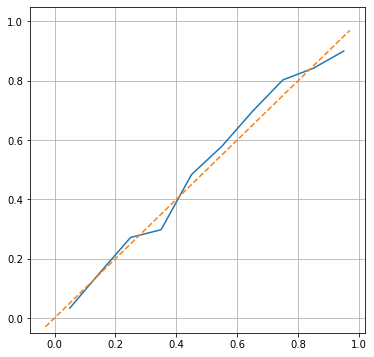

In [49]:
lr = LogisticRegression(penalty='l2', C = 10)
lr.fit(X, y)
reg = lr.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, lr.predict_proba(X_test)[:,1])

In [7]:
from sklearn.svm import LinearSVC

In [35]:
svc = LinearSVC(C = 0.1)

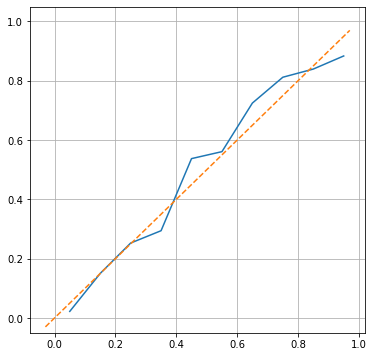

In [36]:
svc = SVC(kernel = 'linear', C = 0.1,probability=True)
svc.fit(X_train, y_train)
sm = svc.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, svc.predict_proba(X_test)[:,1])

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

(array([368., 306., 275., 290., 240., 273., 254., 282., 360., 352.]),
 array([0.00225318, 0.10172015, 0.20118712, 0.30065409, 0.40012106,
        0.49958803, 0.599055  , 0.69852197, 0.79798894, 0.89745591,
        0.99692288]),
 <BarContainer object of 10 artists>)

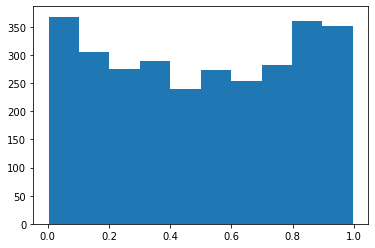

In [37]:
plt.hist(reg)

(array([366., 309., 279., 281., 228., 281., 256., 316., 349., 335.]),
 array([0.00205049, 0.10136249, 0.20067448, 0.29998648, 0.39929847,
        0.49861047, 0.59792246, 0.69723445, 0.79654645, 0.89585844,
        0.99517044]),
 <BarContainer object of 10 artists>)

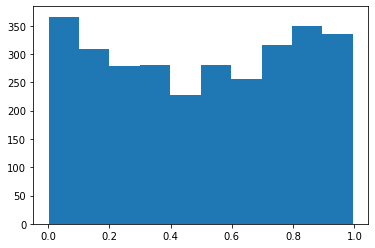

In [38]:
plt.hist(sm)

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [51]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

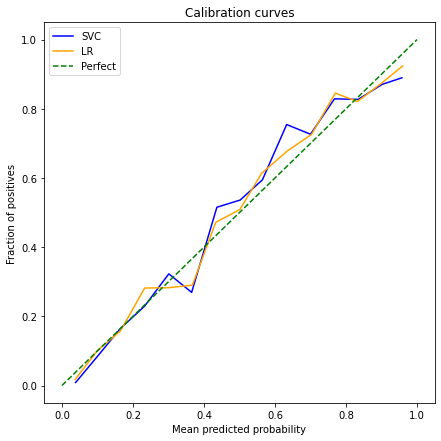

In [39]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sm, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, reg, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

In [40]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8478444564657416


In [56]:
sigmoid_lr = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

Logistic regression ROC-AUC: 0.8479404687979923


In [57]:
precision, recall, _ = precision_recall_curve(y_test, sigmoid_lr_pred)
auc(recall, precision)

0.8291577291360783

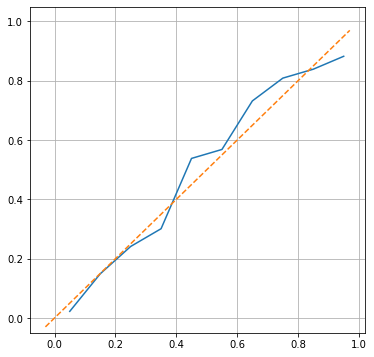

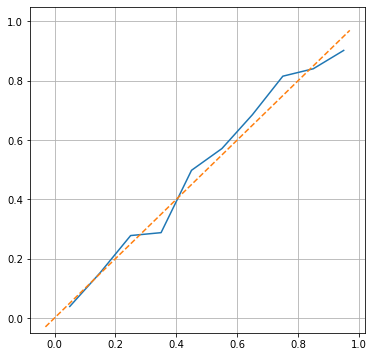

In [319]:
plot_calibration_curve(y_test, sigmoid_svc_pred)
plot_calibration_curve(y_test, sigmoid_lr_pred)

В результате применении калибровки к обеим моделям можно увидеть, что калибровочная кривая для алгоритмы SVC заменто улучшилось, что говорит о более корректном оценивании вероятностей. В случае с Logistic Regression можно также заметить явные улучшения в графике, но уже в более меньше степени.

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__


Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [321]:
!!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

['"wget" \xadҐ пў«пҐвбп ў\xadгваҐ\xad\xadҐ© Ё«Ё ў\xadҐи\xadҐ©',
 'Є®¬\xa0\xad¤®©, ЁбЇ®«\xadпҐ¬®© Їа®Ја\xa0¬¬®© Ё«Ё Ї\xa0ЄҐв\xadл¬ д\xa0©«®¬.']

In [9]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [10]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [324]:
df.shape

(32561, 15)

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income',axis=1), df['income'], test_size=0.75, random_state=777,stratify=df['income'])

#### __Задание. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [14]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [13]:
categorical = list(X_train.dtypes[df.dtypes=='object'].index)
numeric_features = list(X_train.dtypes[(df.dtypes=='int64') | (df.dtypes == 'int32')].index)

In [332]:
import time

start = time.time()

def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

c = [1000,100,10,1,0.1]
sc = []

column_transformer = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = -1), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ord_and_scaling', column_transformer),
    ('reg', LogisticRegression(max_iter=20000))
    ])


searcher = GridSearchCV(pipeline, [{'reg__C': c}],cv=3,scoring = make_scorer(metric))
searcher.fit(X_train, y_train)
end = time.time()
print(end - start)

1.9671995639801025


In [333]:
searcher.best_params_

{'reg__C': 1}

In [334]:
best_ord = searcher.best_estimator_
metric(best_ord.predict_proba(X_test)[:,1],y_test.values)

0.6931429291806062

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: Малое кол-во объектов одного класса(class imbalance)

#### __Задание. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [48]:
import time

start = time.time()

def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

c = [1000,100,10,1,0.1]
sc = []

column_transformer = ColumnTransformer([
    ('ord', OneHotEncoder(handle_unknown = 'ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ord_and_scaling', column_transformer),
    ('reg', LogisticRegression(max_iter=20000))
    ])


searcher = GridSearchCV(pipeline, [{'reg__C': c}],cv=3, scoring = make_scorer(metric))
searcher.fit(X_train, y_train)
end = time.time()
print(end - start)

3.3043723106384277


In [49]:
best_ohe = searcher.best_estimator_
metric(best_ohe.predict_proba(X_test)[:,1],y_test.values)

0.763583745597419

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [51]:
from sklearn.preprocessing import TargetEncoder
import time

start = time.time()

def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

c = [1000,100,10,1,0.1]
sc = []

column_transformer = ColumnTransformer([
    ('ord', TargetEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ord_and_scaling', column_transformer),
    ('reg', LogisticRegression(max_iter=20000))
    ])


searcher = GridSearchCV(pipeline, [{'reg__C': c}],cv=3, n_jobs=2,scoring = make_scorer(metric))
searcher.fit(X_train, y_train)
end = time.time()
print(end - start)

1.6259660720825195


In [52]:
best_mean_tar = searcher.best_estimator_
metric(best_mean_tar.predict_proba(X_test)[:,1],y_test.values)

0.761116103316817

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [96]:
from sklearn.preprocessing import TargetEncoder
import time

start = time.time()

def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

c = [1000,100,10,1,0.1]
sc = []

column_transformer = ColumnTransformer([
    ('ord', TargetEncoder(smooth=122), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ord_and_scaling', column_transformer),
    ('reg', LogisticRegression(max_iter=20000))
    ])


searcher = GridSearchCV(pipeline, [{'reg__C': c}],cv=3, n_jobs=2,scoring = make_scorer(metric))
searcher.fit(X_train, y_train)
end = time.time()
print(end - start)

0.7500143051147461


In [97]:
best_mean_tar = searcher.best_estimator_
metric(best_mean_tar.predict_proba(X_test)[:,1],y_test.values)

0.7604133092295304

#### __Задание. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


#### __Задание. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [120]:
df['hours-per-week'] = df['hours-per-week'].astype('object')
df['age'] = df['age'].astype('object')
numeric_features.remove('age')
numeric_features.remove('hours-per-week')

In [111]:
categorical += ['age','hours-per-week']

In [129]:
from sklearn.preprocessing import TargetEncoder
import time

start = time.time()

def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

c = [1000,100,10,1,0.1]
sc = []

column_transformer = ColumnTransformer([
    ('ord', TargetEncoder(cv=9), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ord_and_scaling', column_transformer),
    ('reg', LogisticRegression(max_iter=20000))
    ])


searcher = GridSearchCV(pipeline, [{'reg__C': c}],cv=3, n_jobs=2,scoring = make_scorer(metric))
searcher.fit(X_train, y_train)
end = time.time()
print(end - start)

0.7904822826385498


In [130]:
best_mean_tar = searcher.best_estimator_
metric(best_mean_tar.predict_proba(X_test)[:,1],y_test.values)

0.7701270285191324

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ не возникает проблемы добавления множества признаков, но в тоже время есть гиперпарамеетры, которые можно настраивать. Также нужно грамотно подойти к кодированию и отслеживать качество на валидации, чтобы контролировать переобучение

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [8]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income',axis=1), df['income'], test_size=0.75, random_state=777,stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [10]:
categorical = list(df.dtypes[df.dtypes=='object'].index)
numer = list(df.dtypes[(df.dtypes=='int64') | (df.dtypes=='int32')].index)
numer.remove('income')

In [16]:
ct = ColumnTransformer([
        ('scaler', StandardScaler(), numer),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ])

In [17]:
ct1 = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

In [36]:
x_train_transf = ct1.fit_transform(X_train)

In [37]:
x_train_transf

<8140x101 sparse matrix of type '<class 'numpy.float64'>'
	with 65120 stored elements in Compressed Sparse Row format>

In [38]:
sc = StandardScaler(with_mean=False)
x_train_transf = sc.fit_transform(x_train_transf)

In [39]:
x_test_transf = ct1.transform(X_test)
x_test_transf = sc.transform(x_test_transf)

In [40]:
def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

model = SVC()
c = [1000, 100, 10, 1, 0.1]
sc = []

for i in c:
    model = LogisticRegression(max_iter=20000, C = i)
    sc.append(np.mean(cross_val_score(model, x_train_transf, y_train, cv=3,scoring = make_scorer(metric))))

In [41]:
sc

[0.6296648963224362,
 0.6296648963224362,
 0.6296648963224362,
 0.6296648963224362,
 0.6297796332551431]

Scaling after Ohe

In [42]:
lr_oh = LogisticRegression(max_iter=20000, C = 1)
lr_oh.fit(x_train_transf, y_train)
precision, recall, _ = precision_recall_curve(y_test, lr_oh.predict_proba(x_test_transf)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.66706


Without scaling

In [300]:
lr_oh = LogisticRegression(max_iter=20000, C = 1)
lr_oh.fit(x_train_transf, y_train)
precision, recall, _ = precision_recall_curve(y_test, lr_oh.predict_proba(x_test_transf)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76358


#### __Задание. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [28]:
coefs = np.abs(lr_oh.coef_[0])
indexes = coefs.argsort()[::-1][:40]

In [29]:
new_x_train = x_train_transf[:, indexes]

In [30]:
new_x_test = x_test_transf[:,indexes]

In [31]:
def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

model = SVC()
c = [1000, 100, 10, 1, 0.1]
sc = []

for i in c:
    model = LogisticRegression(max_iter=20000, C = i)
    sc.append(np.mean(cross_val_score(model, new_x_train, y_train, cv=3,scoring = make_scorer(metric))))

In [32]:
sc

[0.6338031469605862,
 0.6341604484870337,
 0.6338031469605862,
 0.6338031469605862,
 0.6350105523073726]

Scaling before OHE

In [291]:
lr_oh = LogisticRegression(max_iter=20000, C = 0.1)
lr_oh.fit(new_x_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, lr_oh.predict_proba(new_x_test)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.75235


Scaling after OHE

In [33]:
lr_oh = LogisticRegression(max_iter=20000, C = 10)
lr_oh.fit(new_x_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, lr_oh.predict_proba(new_x_test)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67100


#### __Задание. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [11]:
def metric(x,y):
    precision, recall, _ = precision_recall_curve(y, x)
    return auc(recall, precision)

In [12]:
categorical = list(df.dtypes[df.dtypes=='object'].index)
numer = list(df.dtypes[(df.dtypes=='int64') | (df.dtypes=='int32')].index)
numer.remove('income')

In [15]:
x_cat = X_train.loc[:,categorical]

r = OneHotEncoder(handle_unknown='ignore',categories='auto')

feature_arr = r.fit_transform(x_cat).toarray()

ohe_labels = r.get_feature_names_out()

features = pd.DataFrame(
               feature_arr,
               columns=ohe_labels,index = X_train.index)

x_bin = X_train.loc[:,numer]

e = StandardScaler()

feature_ar = e.fit_transform(x_bin)

ohe_labels = e.get_feature_names_out()

feat = pd.DataFrame(
               feature_ar,
               columns=ohe_labels,index = X_train.index)

X_dummies = pd.concat([feat,features],axis=1)

In [16]:
x_cat_test = X_test.loc[:,categorical]

feature_arr = r.transform(x_cat_test).toarray()

ohe_labels = r.get_feature_names_out()

features = pd.DataFrame(
               feature_arr,
               columns=ohe_labels,index = X_test.index)

x_bin = X_test.loc[:,numer]

feature_ar = e.transform(x_bin)

ohe_labels = e.get_feature_names_out()

feat = pd.DataFrame(
               feature_ar,
               columns=ohe_labels,index = X_test.index)

X_dummies_test = pd.concat([feat,features],axis=1)

In [17]:
ct = ColumnTransformer([
        ('scaler', StandardScaler(), numer),
        ('pass', 'passthrough', list(X_dummies.columns))
    ])

model = LogisticRegression(max_iter = 20000, C=1)
model.fit(X_dummies, y_train)

#x_test_modif = pd.(X_test)

loss = np.mean(cross_val_score(model, X_dummies, y_train, cv=2,scoring = make_scorer(metric)))

#precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_dummies)[:,1])

take_fu=list(X_dummies.columns)
colu = list(X_dummies.columns)

for i in X_dummies.columns:
    numer_cop = colu.copy()
    numer_cop.remove(i)
#     ct2 = ColumnTransformer([
#         ('scaler', StandardScaler(), numer_cop),
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cop),
#     ])
    if len(take_fu)==40:
        break
    model = LogisticRegression(max_iter=20000, C=1)
    l = np.mean(cross_val_score(model, X_dummies.loc[:,numer_cop], y_train, cv=2,scoring = make_scorer(metric)))
    if l >= loss:
        take_fu.remove(i)

In [18]:
len(take_fu)

40

In [19]:
np.mean(cross_val_score(model, X_dummies.loc[:,take_fu], y_train, cv=2,scoring = make_scorer(metric)))

0.6247912646371283

In [61]:
model = LogisticRegression(max_iter=20000, C=1)
model.fit(X_dummies.loc[:,take_fu], y_train)
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_dummies_test.loc[:,take_fu])[:,1])
auc(recall, precision)

0.7190462098608147

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [22]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [23]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [24]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [28]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=500)
kf.get_n_splits(X)

5

In [31]:
(X.dtypes[X.dtypes=='object']).index

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [81]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

losses = []
categorical = list((X.dtypes[X.dtypes=='object']).index)
numeric_features = list((X.dtypes[(X.dtypes=='int64') | (X.dtypes=='float64')]).index)
column_transformer = ColumnTransformer([
    ('ord', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

model = LogisticRegression(max_iter = 20000, C=1)
revenue = []
calls = []

for i, (train_index,test_index) in enumerate(kf.split(X)):
    train_data = column_transformer.fit_transform(X.iloc[train_index])
    model.fit(train_data, y.iloc[train_index])
    test_data = column_transformer.transform(X.iloc[test_index])
    precision, recall, _ = precision_recall_curve(y.iloc[test_index], model.predict_proba(test_data)[:,1])
    losses.append(auc(recall, precision))
    revenue.append((np.random.uniform(0,20, ((model.predict(test_data) & y.iloc[test_index])).sum())).sum())
    calls.append((model.predict(test_data)==1).sum())

In [79]:
losses

[0.48013949303325376,
 0.4378093572785718,
 0.4499883065995878,
 0.46031207148266745,
 0.4308820936362544]

Uniform revenue

In [82]:
revenue = [i*10 for i in revenue]
print(revenue)
np.mean(revenue)

[24115.656633178, 20869.432592661233, 21828.83225401437, 23013.520160896594, 20335.258973396518]


22032.54012282934

In [76]:
calls

[310, 330, 331, 330, 322]

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

Если затраты на один звонок составляют 1\\$, а согласние клиента приносит [0,20]\\$ (normal distribution), то ожидаемый доход компании составляет 22032$ \
Откуда 326\\$ долларов мы потратим на выплату операторам, а прибыль составит 21706\\$

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [93]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

losses = []
categorical = list((X.dtypes[X.dtypes=='object']).index)
numeric_features = list((X.dtypes[(X.dtypes=='int64') | (X.dtypes=='float64')]).index)
column_transformer = ColumnTransformer([
    ('ord', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

profit = []
calls = []
coefs = [1000,100,10,1,0.1]

for c in coefs:
    pr = []
    model = LogisticRegression(max_iter = 20000, C=c)
    for i, (train_index,test_index) in enumerate(kf.split(X)):
        train_data = column_transformer.fit_transform(X.iloc[train_index])
        model.fit(train_data, y.iloc[train_index])
        test_data = column_transformer.transform(X.iloc[test_index])
        pr.append( ((np.random.uniform(0,20, ((model.predict(test_data) & y.iloc[test_index])).sum())).sum()) - 
                  (model.predict(test_data)==1).sum())
    profit.append(np.mean(pr)) 

Test1

In [85]:
profit

[1790.5157858026607,
 1831.3893230053131,
 1765.4189988448677,
 1765.4081922995924,
 1772.683590941228]

Test2

In [88]:
profit

[1835.169905202793,
 1815.8678136213741,
 1785.2345173327387,
 1870.194650793291,
 1790.7030629614515]

Test3

In [90]:
profit

[1834.0006606559796,
 1781.1734123900162,
 1814.6047078814306,
 1860.030954256493,
 1771.5390591054615]

Test4

In [92]:
profit

[1816.3534902542,
 1833.671425563463,
 1796.9460399853074,
 1784.0966859620523,
 1774.4007462930817]

Test5

In [94]:
profit

[1769.2476630857204,
 1752.3092666969023,
 1836.4900687120366,
 1888.9941556945093,
 1749.7594069613774]

#### __Задание. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ если стремить получить прибыль как можно больше - то важнее хороший recall, так как клиент приносит значительно больше банку, чем стоимость звонка. Поэтому выгоднее позвонить "на всякий случай" побольше клиентам, чтобы увиличить потенциальную прибль


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [100]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

losses = []
categorical = list((X.dtypes[X.dtypes=='object']).index)
numeric_features = list((X.dtypes[(X.dtypes=='int64') | (X.dtypes=='float64')]).index)
column_transformer = ColumnTransformer([
    ('ord', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

model = LogisticRegression(max_iter = 20000, C=1)
profit = {i/100: 0 for i in range(0,101,1)}
calls = []
coefs = np.arange(0,1+0.01,0.01)

for c in coefs:
    pr = []
    for i, (train_index,test_index) in enumerate(kf.split(X)):
        train_data = column_transformer.fit_transform(X.iloc[train_index])
        model.fit(train_data, y.iloc[train_index])
        test_data = column_transformer.transform(X.iloc[test_index])
        pr.append( ((np.random.uniform(0,20, (( (model.predict_proba(test_data)[:,1] >= c) & y.iloc[test_index])).sum())).sum()) - 
                  (model.predict(test_data)==1).sum())
    profit[c] = np.mean(pr)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 

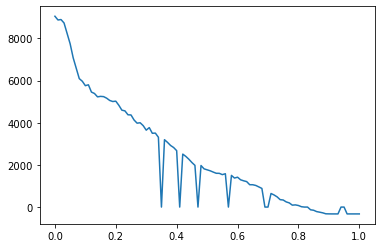

In [117]:
plt.plot(coefs,list(profit.values())[:-10])

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [126]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

losses = []
categorical = list((X.dtypes[X.dtypes=='object']).index)
numeric_features = list((X.dtypes[(X.dtypes=='int64') | (X.dtypes=='float64')]).index)
column_transformer = ColumnTransformer([
    ('ord', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

model = LogisticRegression(max_iter = 20000, C=1)
pr = []
rec = []


for i, (train_index,test_index) in enumerate(kf.split(X)):
    train_data = column_transformer.fit_transform(X.iloc[train_index])
    model.fit(train_data, y.iloc[train_index])
    test_data = column_transformer.transform(X.iloc[test_index])
    precision, recall, trsh = precision_recall_curve(y.iloc[test_index], (model.predict_proba(test_data)[:,1] >= 0))
    pr.append(precision)
    rec.append(recall)
    print(trsh)

[ True]
[ True]
[ True]
[ True]
[ True]


In [135]:
print(np.mean(pr,axis=0)[0])
np.mean(rec,axis=0)[0]

0.11265416267404435


1.0

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

AUC-PR: 0.52443


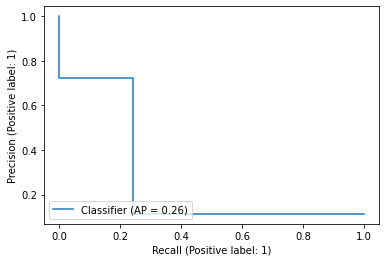

In [141]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

losses = []
categorical = list((X.dtypes[X.dtypes=='object']).index)
numeric_features = list((X.dtypes[(X.dtypes=='int64') | (X.dtypes=='float64')]).index)
column_transformer = ColumnTransformer([
    ('ord', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

model = LogisticRegression(max_iter = 20000, C=1)
pr = []
rec = []


for i, (train_index,test_index) in enumerate(kf.split(X)):
    if i>0:
        break
    train_data = column_transformer.fit_transform(X.iloc[train_index])
    model.fit(train_data, y.iloc[train_index])
    test_data = column_transformer.transform(X.iloc[test_index])

    PrecisionRecallDisplay.from_predictions(y.iloc[test_index], model.predict(test_data))
    precision, recall, _ = precision_recall_curve(y.iloc[test_index], model.predict(test_data))
    print('AUC-PR: %.5f' % auc(recall, precision))

In [ ]:
PrecisionRecallDisplay.from_predictions(y_test, y_random)
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))